<a href="https://colab.research.google.com/github/kwanhong66/KaggleShoveling/blob/master/Classifying_multi_label_comments_(0_9741_lb).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle kernal transcription study #10-1
### Toxic Comment Classification Challenge

- Kernal 주소
  * https://www.kaggle.com/rhodiumbeng/classifying-multi-label-comments-0-9741-lb
- Dataset 주소
  * https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

## Dataset with Kaggle API

In [0]:
!pip3 install -q kaggle

In [2]:
!wget 'https://raw.githubusercontent.com/kwanhong66/KaggleShoveling/master/token/kaggle.json'

--2020-05-21 06:02:51--  https://raw.githubusercontent.com/kwanhong66/KaggleShoveling/master/token/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      63  --.-KB/s    in 0s      

2020-05-21 06:02:52 (3.25 MB/s) - ‘kaggle.json’ saved [63/63]



In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions list

ref                                               deadline             category            reward  teamCount  userHasEntered  
------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                  2030-01-01 00:00:00  Getting Started  Knowledge       3019           False  
titanic                                           2030-01-01 00:00:00  Getting Started  Knowledge      22288            True  
house-prices-advanced-regression-techniques       2030-01-01 00:00:00  Getting Started  Knowledge       5161            True  
connectx                                          2030-01-01 00:00:00  Getting Started  Knowledge        400           False  
nlp-getting-started                               2030-01-01 00:00:00  Getting Started      Kudos       1933           False  
competitive-data-science-predict-future-sales     2020-12-31 23:59:00  Playground           Kudos       6880   

In [6]:
!kaggle competitions download jigsaw-toxic-comment-classification-challenge

  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 47.9MB/s]
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 95.6MB/s]
 65% 17.0M/26.3M [00:00<00:00, 35.7MB/s]
100% 26.3M/26.3M [00:00<00:00, 66.6MB/s]
 43% 10.0M/23.4M [00:00<00:00, 27.0MB/s]
100% 23.4M/23.4M [00:00<00:00, 59.3MB/s]


In [0]:
!mkdir input

In [8]:
!unzip '*.zip' -d ./input/

Archive:  sample_submission.csv.zip
  inflating: ./input/sample_submission.csv  

Archive:  train.csv.zip
  inflating: ./input/train.csv       

Archive:  test_labels.csv.zip
  inflating: ./input/test_labels.csv  

Archive:  test.csv.zip
  inflating: ./input/test.csv        

4 archives were successfully processed.


## Classifying multi-label comments with Logistic Regression

Rhodium Beng
Started on 20 December 2017

This kernel is inspired by:

kernel by Jeremy Howard : NB-SVM strong linear baseline + EDA (0.052 lb)
kernel by Issac : logistic regression (0.055 lb)
Solving Multi-Label Classification problems, https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/

In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load training and test data

In [0]:
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')

## Examine the data (EDA)

In [11]:
train_df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
150907,73ff831a51dc1620,Speedy deletion criterion A1 didn't apply; I t...,0,0,0,0,0,0
139755,ebeb24f8a6d1fd22,Ravenkills97\n\nI didn't change the genres on ...,1,0,1,0,0,0
91475,f49286f41db757b0,I took off Slim Shady LP and MMLP because they...,0,0,0,0,0,0
41114,6db7af873006a6ee,"""\n\nPLEASE DO NOT HURT ME TRYPTOFISH!!!!!! I ...",0,0,0,0,0,0
148090,46b2ab821941ed5a,It would probably be helpful if you could find...,0,0,0,0,0,0


In the training data, the comments are labelled as one or more of the six categories; toxic, severe_toxic, obscene, threat, insult, identity_hate. This is essentially a multi-label classification problem.

In [0]:
cols_target = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [13]:
# check missing values in numeric columns
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


There are no missing numeric values. As the mean values are very small (some way below 0.05), there would be many not labelled as positive in the six categories. From this, I guess that there would be many comments which are not labelled in any of the six categories. Let's take a look.

In [14]:
unlabelled_in_all = train_df[(train_df['toxic'] != 1) & (train_df['severe_toxic'] != 1)
                             & (train_df['obscene'] != 1) & (train_df['threat'] != 1)
                             & (train_df['insult'] != 1) & (train_df['identity_hate'] != 1)]
print('Percentage of unlabelled comments is ', len(unlabelled_in_all) / len(train_df) * 100)                             

Percentage of unlabelled comments is  89.83211235124176


In [15]:
# check for any 'null' comment
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

In [16]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [17]:
no_comment = test_df[test_df['comment_text'].isnull()]
no_comment

,id,comment_text


All rows in the training and test data contains comments, so there's no need to clean up null fields.

In [18]:
# let's see the total rows in train, test data and the numbers for the various categories
print("Total rows in test is {}".format(len(test_df)))
print("Total rows in train is {}".format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 153164
Total rows in train is 159571
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


As mentioned earlier, majority of the comments in the training data are not labelled in one or more of these categories.

In [0]:
# Let's look at the character length for the rows in the training data and record these
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))

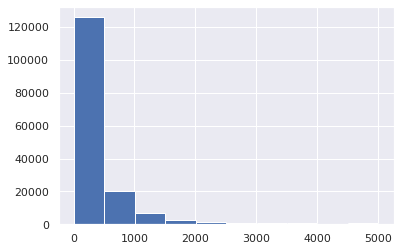

In [20]:
# look at the histogram plot for text length
sns.set()
train_df['char_length'].hist()
plt.show()

Most of the text length within 500 characters, with some up to 5,000 characters long.

Next, let's examine the correlations among the target variables.

In [0]:
data = train_df[cols_target]

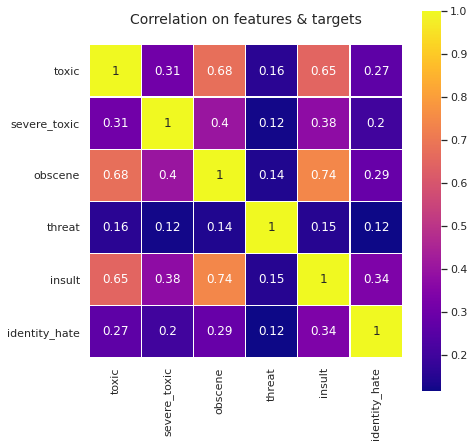

In [22]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation on features & targets', y=1.05, size=14)
sns.heatmap(data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, 
            annot=True, cmap=colormap, linecolor='white')

Indeed, it looks like some of the labels are higher correlated, e.g. insult-obscene has the highest at 0.74, followed by toxic-obscene and toxic-insult.

What about the character length & distribution of the comment text in the test data?

In [0]:
test_df['char_length'] = test_df['comment_text'].apply(lambda x: len(str(x)))

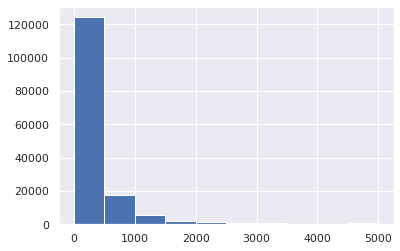

In [24]:
plt.figure()
plt.hist(test_df['char_length'])
plt.show()

Now, the shape of character length distribution looks similar between the training data and the train data. For the training data, I guess the train data were clipped to 5,000 characters to facilitate the folks who did the labelling of the comment categories.

## Clean up the comment text

In [0]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text  

In [0]:
# clean the comment_text in train_df 
train_df['comment_text'] = train_df['comment_text'].map(lambda com: clean_text(com))

In [0]:
# clean the comment_text in test_df
test_df['comment_text'] = test_df['comment_text'].map(lambda com: clean_text(com))

## Define X from entire train & test data for use in tokenization by Vectorizer

In [0]:
train_df = train_df.drop('char_length', axis=1)

In [0]:
X = train_df.comment_text
test_X = test_df.comment_text

In [30]:
print(X.shape, test_X.shape)

(159571,) (153164,)


### Vectorize the data

In [32]:
# https://datascienceschool.net/view-notebook/3e7aadbf88ed4f0d87a76f9ddc925d69/
# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(max_features=5000, stop_words='english')
vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [33]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect.fit_transform(X)
X_dtm

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3178792 stored elements in Compressed Sparse Row format>

In [34]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
test_X_dtm = vect.transform(test_X)
test_X_dtm

<153164x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2618972 stored elements in Compressed Sparse Row format>

## Solving a multi-label classification problem

One way to approach a multi-label classification problem is to transform the problem into separate single-class classifier problems. This is known as 'problem transformation'. There are three methods:

* __Binary Relevance.__ This is probably the simplest which treats each label as a separate single classification problems. The key assumption here though, is that there are no correlation among the various labels.

* __Classifier Chains.__ In this method, the first classifier is trained on the input X. Then the subsequent classifiers are trained on the input X and all previous classifiers' predictions in the chain. This method attempts to draw the signals from the correlation among preceding target variables.

* __Label Powerset.__ This method transforms the problem into a multi-class problem where the multi-class labels are essentially all the unique label combinations. In our case here, where there are six labels, Label Powerset would in effect turn this into a 2^6 or 64-class problem. {Thanks Joshua for pointing out.}

### Binary Relevance - build a multi-label classifier using Logistic Regression

In [37]:
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C=12.0, max_iter=1000)

# create submission file
submission_binary = pd.read_csv('./input/sample_submission.csv')

for label in cols_target:
  print('... Processing {}'.format(label))
  y = train_df[label]
  # train the model using X_dtm & y
  logreg.fit(X_dtm, y)
  # compute the training accuracy
  y_pred_X = logreg.predict(X_dtm)
  print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
  # compute the predicted probabilities for X_test_dtm
  test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
  submission_binary[label] = test_y_prob

... Processing toxic
Training accuracy is 0.9639972175395278
... Processing severe_toxic
Training accuracy is 0.9920724943755445
... Processing obscene
Training accuracy is 0.9832300355327722
... Processing threat
Training accuracy is 0.9981199591404453
... Processing insult
Training accuracy is 0.9755406684171936
... Processing identity_hate
Training accuracy is 0.9939650688408295


**Create submission file**

In [38]:
submission_binary.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999957,0.464040,0.999965,0.050385,0.971129,0.431952
1,0000247867823ef7,0.002398,0.000430,0.000400,0.000326,0.003280,0.000394
2,00013b17ad220c46,0.011102,0.000118,0.003178,0.000035,0.007277,0.001248
3,00017563c3f7919a,0.001328,0.002133,0.000965,0.000117,0.000873,0.000033
4,00017695ad8997eb,0.019292,0.000831,0.001250,0.000601,0.003279,0.000564


In [0]:
# generate submission file
submission_binary.to_csv('submission_binary.csv',index=False)

**Binary Relevance with Logistic Regression classifier scored 0.074 on the public leaderboard.**

### Classifier Chains - build a multi-label classifier using Logistic Regression

In [0]:
# create submission file
submission_chains = pd.read_csv('./input/sample_submission.csv')

# create a function to add features
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [42]:
for label in cols_target:
  print('... Processing {}'.format(label))
  y = train_df[label]
  # train the model using X_dtm & y
  logreg.fit(X_dtm, y)
  # compute the training accuracy
  y_pred_X = logreg.predict(X_dtm)
  print('Training Accuracy is {}'.format(accuracy_score(y, y_pred_X)))
  # make predictions from test_X
  test_y = logreg.predict(test_X_dtm)
  test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
  submission_chains[label] = test_y_prob
  # chain current label to X_dtm
  X_dtm = add_feature(X_dtm, y)
  print('Shape of X_dtm is now {}'.format(X_dtm.shape))
  # chain current label predictions to test_X_dtm
  test_X_dtm = add_feature(test_X_dtm, test_y)
  print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))  

... Processing toxic
Training Accuracy is 0.9639972175395278
Shape of X_dtm is now (159571, 5001)
Shape of test_X_dtm is now (153164, 5001)
... Processing severe_toxic
Training Accuracy is 0.9926239730276805
Shape of X_dtm is now (159571, 5002)
Shape of test_X_dtm is now (153164, 5002)
... Processing obscene
Training Accuracy is 0.9852980804782824
Shape of X_dtm is now (159571, 5003)
Shape of test_X_dtm is now (153164, 5003)
... Processing threat
Training Accuracy is 0.9984395660865696
Shape of X_dtm is now (159571, 5004)
Shape of test_X_dtm is now (153164, 5004)
... Processing insult
Training Accuracy is 0.9826973572892318
Shape of X_dtm is now (159571, 5005)
Shape of test_X_dtm is now (153164, 5005)
... Processing identity_hate
Training Accuracy is 0.9956195047972376
Shape of X_dtm is now (159571, 5006)
Shape of test_X_dtm is now (153164, 5006)


**Create submission file**

In [43]:
submission_chains.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999957,4.360746e-01,0.999691,0.082303,0.858750,0.554349
1,0000247867823ef7,0.002398,1.561908e-06,0.000228,0.000079,0.003226,0.000124
2,00013b17ad220c46,0.011102,5.866660e-07,0.000978,0.000013,0.002517,0.000557
3,00017563c3f7919a,0.001328,2.700775e-05,0.001105,0.000063,0.000421,0.000006
4,00017695ad8997eb,0.019292,2.053004e-06,0.000321,0.000163,0.000842,0.000099


In [0]:
# generate submission file
submission_chains.to_csv('submission_chains.csv', index=False)

### Create a combined submission

In [0]:
# create submission file
submission_combined = pd.read_csv('./input/sample_submission.csv')

Combine using simple average from Binary Relevance and Classifier Chains.

In [0]:
# corr_targets = ['obscene', 'insult', 'toxic']
for label in cols_target:
  submission_combined[label] = 0.5 * (submission_chains[label] + submission_binary[label])

In [48]:
submission_combined.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999957,0.450057,0.999828,0.066344,0.914939,0.493151
1,0000247867823ef7,0.002398,0.000216,0.000314,0.000202,0.003253,0.000259
2,00013b17ad220c46,0.011102,0.000059,0.002078,0.000024,0.004897,0.000902
3,00017563c3f7919a,0.001328,0.001080,0.001035,0.000090,0.000647,0.000020
4,00017695ad8997eb,0.019292,0.000416,0.000786,0.000382,0.002061,0.000332


In [0]:
# generate submission file
submission_combined.to_csv('submission_combined.csv', index=False)